In [176]:
import ROOT
import pandas as pd
import numpy as np
import seaborn as sns
import re
from utils import to_data_frame
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
filename = "/lustre/r3b/ywang/calibration/s515/run49x/millepede/cal.par.root"
root_file = ROOT.TFile(filename, "read")
data_frame = to_data_frame(root_file)

size of module pars: 1000


In [113]:
def get_run_header_num(str_line):
    res =  re.search(r"NR[\s]*([0-9]*)\s.*", str_line)
    if res == None:
        return -1
    return int(res.group(1))

def check_if_global(str_line):
    return re.search(r"-g-", str_line) != None
    
def check_if_header(str_line):
    return re.search(r"meas\.", str_line) != None

def check_if_data_line(str_line):
    return re.search(r"(local|global)", str_line) != None
    
def get_measurement(header_line):
    res = re.search(r"-(l|g)- meas\.\s*[0-9\.]*\s[0-9\.]*\s[0-9\.]*\s[0-9\.]*\s([-\d\.]*)\s([-\d\.]*)", header_line)
    return res.group(1), float(res.group(2)), float(res.group(3))

def get_par_values(data_line_str):
    res = re.search(r"(local|global)\s*\[([-\d\.]*)\, ([-\d\.]*)\]", data_line_str)
    return float(res.group(2)), float(res.group(3))

In [185]:
filename = "/lustre/r3b/ywang/calibration/s515/run49x/millepede/data.txt"


x_bar_num = []
x_factors = []
x_results = []
x_results_error = []
x_labels = []

y_bar_num = []
y_factors = []
y_results = []
y_results_error = []
y_labels = []

def fill_entry(datafile):
    header = datafile.readline()
    bar_number = np.nan
    if not check_if_header(header):
        return False
    gl_label, meas, error = get_measurement(header)
    local_a_id, local_b_id = get_par_values(datafile.readline())
    a_factor, _ = get_par_values(datafile.readline())
    if(gl_label == "g"):
        gct_id, gc_id = get_par_values(datafile.readline())
        gct_factor, gc_factor = get_par_values(datafile.readline())
        
        gc = data_frame.loc[gct_id - 1, "effective_speed"]
        gct = gc * data_frame.loc[gct_id - 1, "t_diff"] / 100.
        meas = meas - gct_factor * gct -  gc * gc_factor
        bar_number = gct_id

    if local_a_id == 1 and local_b_id == 3:
        x_factors.append(a_factor)
        x_results.append(meas)
        x_results_error.append(error)
        x_bar_num.append(bar_number)
        x_labels.append(gl_label)
    else:
        y_factors.append(a_factor)
        y_results.append(meas)
        y_results_error.append(error)
        y_bar_num.append(bar_number)
        y_labels.append(gl_label)
    
    return True
            
def go_to_run_number(run_number, datafile):
    while (str_line := datafile.readline()) != None:
        if(get_run_header_num(str_line) >= run_number):
            return

with open(filename) as datafile:
    go_to_run_number(3, datafile)
    while fill_entry(datafile):
        pass

dataframe_x = pd.DataFrame({"bar_num": x_bar_num ,"factors": x_factors, "measures": x_results, "errors": x_results_error, "labels": x_labels});
dataframe_y = pd.DataFrame({"bar_num": y_bar_num ,"factors": y_factors, "measures": y_results, "errors": y_results_error, "labels": y_labels});


In [186]:
print(dataframe_x)
print(dataframe_y)

    bar_num  factors  measures  errors labels
0     538.0    0.525  1.046749   0.040      g
1     539.0    0.525  1.122867   0.040      g
2       NaN    0.575  1.075000   0.025      l
3       NaN    0.575  1.125000   0.025      l
4     635.0    0.625  0.938425   0.040      g
5     636.0    0.625  1.002480   0.040      g
6       NaN    0.675  0.875000   0.025      l
7       NaN    0.675  0.925000   0.025      l
8     732.0    0.725  0.770747   0.040      g
9     733.0    0.725  0.729089   0.040      g
10      NaN    0.775  0.675000   0.025      l
11      NaN    0.775  0.725000   0.025      l
12      NaN    0.775  0.775000   0.025      l
13    829.0    0.825  0.515656   0.040      g
14    830.0    0.825  0.560503   0.040      g
15      NaN    0.875  0.475000   0.025      l
16      NaN    0.875  0.525000   0.025      l
17      NaN    0.875  0.575000   0.025      l
18    926.0    0.925  0.427208   0.040      g
19    927.0    0.925  0.416872   0.040      g
20    928.0    0.925  0.443018   0

In [208]:
def PlotDF(dataframe):
    sns.scatterplot(data = dataframe, x = "factors", y = "measures", hue = "labels", palette = {"l":"red", "g":"blue"})
    dataframe_l = dataframe[dataframe.labels == "l"]
    dataframe_g = dataframe[dataframe.labels == "g"]
    plt.errorbar(x = dataframe_l["factors"], y = dataframe_l["measures"], yerr = dataframe_l["errors"], linestyle = "", capsize = 4, ecolor = "red")
    plt.errorbar(x = dataframe_g["factors"], y = dataframe_g["measures"], yerr = dataframe_g["errors"], linestyle = "", capsize = 4, ecolor = "blue")
    plt.xlabel("z (m)")
    plt.ylabel("x_or_y (m)")

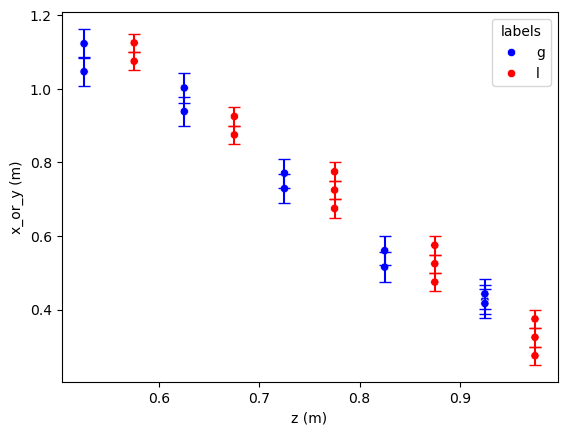

In [209]:
PlotDF(dataframe_x)

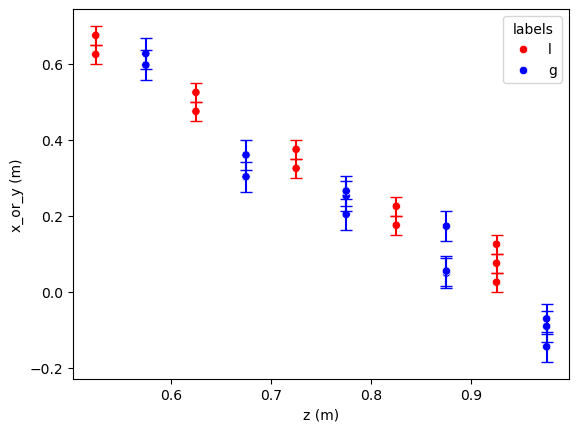

In [210]:
PlotDF(dataframe_y)